<a href="https://colab.research.google.com/github/petron23/ML_random_projects/blob/main/MNIST_classification_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [3]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:01<00:00, 16978923.08it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 304010.46it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5398313.85it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6204677.30it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
print(train_data.classes, train_data.transforms, train_data.targets, len(train_data.data), len(train_data.targets))

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] StandardTransform
Transform: ToTensor() tensor([9, 0, 0,  ..., 3, 0, 5]) 60000 60000


In [5]:
image, label = train_data[0]
print(image.shape)
print(label)

torch.Size([1, 28, 28])
9


Image shape: torch.Size([1, 28, 28])


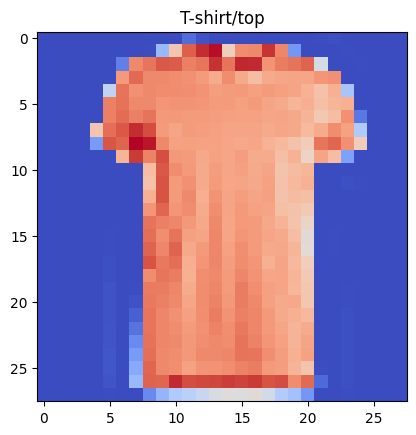

In [6]:
image, label = train_data[17]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze(), cmap = "coolwarm")
plt.title(train_data.classes[label]);

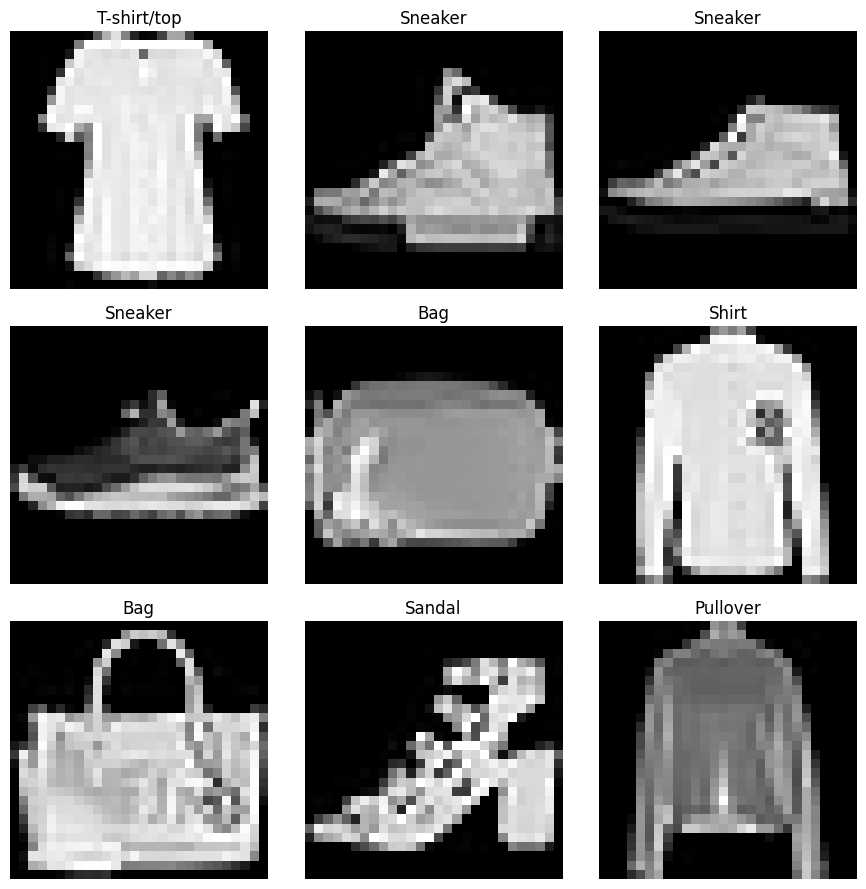

In [8]:
import random

torch.manual_seed(42)

fig, axs = plt.subplots(3, 3, figsize=(9, 9))

for ax in axs.flat:
    random_idx = random.randint(0, len(train_data) - 1)
    img, label = train_data[random_idx]

    ax.imshow(img.squeeze(), cmap="gray")
    ax.set_title(train_data.classes[label])
    ax.axis('off')

plt.tight_layout()


In [9]:
#Loading data
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")


Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7ab86342a6b0>, <torch.utils.data.dataloader.DataLoader object at 0x7ab86342af50>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [10]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 9, label size: torch.Size([])


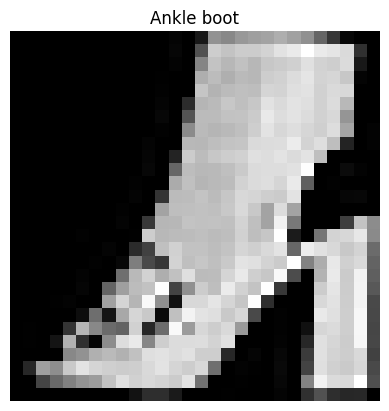

In [11]:
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]

plt.imshow(img.squeeze(), cmap="gray")
plt.title(train_data.classes[label])
plt.axis("Off")

print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")


## Model 0 --> linear model

In [15]:
from torch import nn

class MNISTClassif(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden_units: int):
      super().__init__()
      self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
        )
    def forward(self, x):
      return self.layer_stack(x)

In [16]:
torch.manual_seed(42)

model_0 = MNISTClassif(input_shape=784,
    hidden_units=10,
    output_shape=len(train_data.classes)
)
model_0.to("cpu")

MNISTClassif(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [23]:
!pip install torchmetrics

import torchmetrics

accuracy_fn = torchmetrics.Accuracy(task = 'multiclass', num_classes=len(train_data.classes)).to("cpu")
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(), lr=0.1)

In [24]:
#creating a timer function
import time

def timer(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Function {func.__name__} took {elapsed_time:.4f} seconds to execute.")
        return result
    return wrapper

In [ ]:
from tqdm.auto import tqdm
torch.manual_seed(42)

epochs = 3

@timer
